In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/04_tech/textile_defect.zip'
extract_path = '/content/textile_defect_detection'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
!ls textile_defect_detection

matchingtDATASET_test_32.h5   matchingtDATASET_train_64.h5  test64.csv	 train32.h5
matchingtDATASET_test_64.h5   test32.csv		    test64.h5	 train64.csv
matchingtDATASET_train_32.h5  test32.h5			    train32.csv  train64.h5


In [ ]:
import h5py

with h5py.File('textile_defect_detection/train64.h5', 'r') as f:
    print("Keys in the HDF5 file:")
    print(list(f.keys()))

Keys in the HDF5 file:
['images']


In [ ]:
import pandas as pd

df = pd.read_csv("textile_defect_detection/train64.csv")
print(df.head())
print(df.columns)

   index  angle indication_type  indication_value  split
0  48000      0            good                 0  train
1  48001     80            good                 0  train
2  48002    100            good                 0  train
3  48003    100            good                 0  train
4  48004      0            good                 0  train
Index(['index', 'angle', 'indication_type', 'indication_value', 'split'], dtype='object')


In [ ]:
print(df['indication_type'].value_counts())

indication_type
good                   8000
color                  8000
cut                    8000
hole                   8000
metal_contamination    8000
thread                 8000
Name: count, dtype: int64


In [ ]:
import h5py
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [ ]:
class TextileImageDataset(Dataset):
    def __init__(self, h5_path, csv_path, transform=None):
        self.h5_file = h5py.File(h5_path, 'r')
        self.images = self.h5_file['images'][:]
        self.labels = pd.read_csv(csv_path)['indication_value'].values
        self.categories = pd.read_csv(csv_path)['indication_type'].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        category = self.categories[idx]

        if img.ndim == 3 and img.shape[0] in [1, 3]:  # channels-first
            img = img.transpose(1, 2, 0)
        if img.ndim == 2:
            img = np.expand_dims(img, axis=2)
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)

        if img.max() <= 1.0:
            img = img * 255.0
        img = np.clip(img, 0, 255).astype(np.uint8)

        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, label, category

In [ ]:
from torch.utils.data import random_split, DataLoader
import os

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception V3 必須
    transforms.ToTensor(),  # PIL → Tensor
])

dataset = TextileImageDataset(os.path.join(extract_path, 'train64.h5'), os.path.join(extract_path,'train64.csv'), transform=transform)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(dataset, num_samples=9):
    plt.figure(figsize=(8, 8))
    for i in range(num_samples):
        img, label, category = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()  # C×H×W → H×W×C

        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label}, {category}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


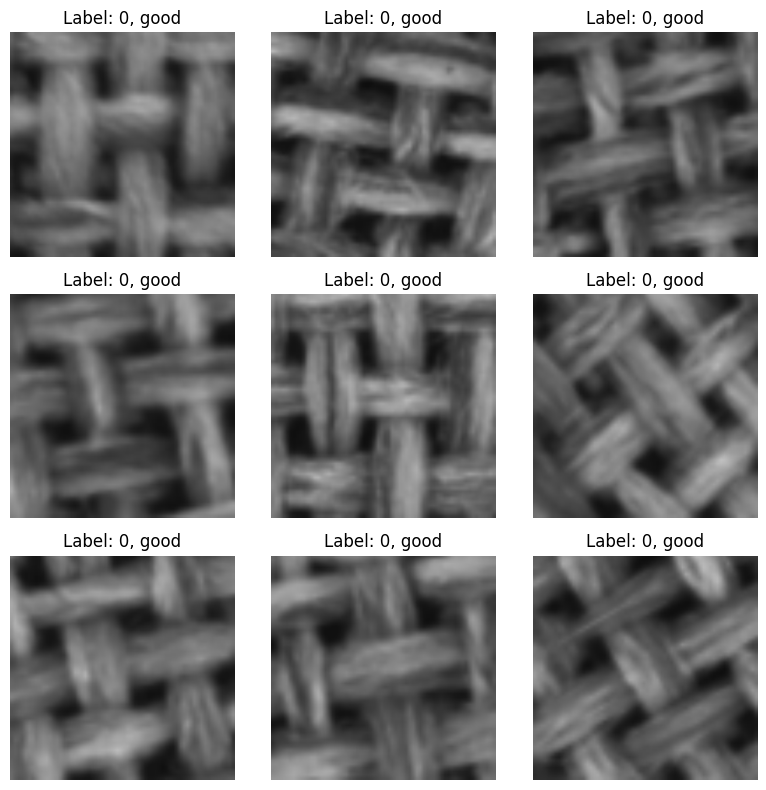

In [ ]:
show_samples(dataset, num_samples=9)

In [ ]:
def show_one_per_class(dataset):
    import matplotlib.pyplot as plt

    found = {}
    plt.figure(figsize=(10, 3))

    for i in range(len(dataset)):
        img, _, category = dataset[i]
        if category not in found:
            found[category] = img

    for i, (category, img) in enumerate(found.items()):
        img_np = img.permute(1, 2, 0).numpy()

        plt.subplot(1, len(found), i + 1)
        plt.imshow(img_np)
        plt.title(category)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


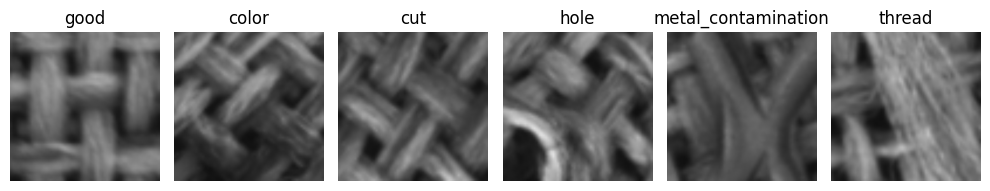

In [ ]:
show_one_per_class(dataset)

In [ ]:
from torchvision import models
import torch.nn as nn

def get_inception_model(num_classes=6):
    model = models.inception_v3(pretrained=True, aux_logits=True)
    in_features_main = model.fc.in_features
    model.fc = nn.Linear(in_features_main, num_classes)

    in_features_aux = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(in_features_aux, num_classes)
    return model

In [ ]:
# --- 1. Dataset の読み込み ---
full_dataset = TextileImageDataset(
    os.path.join(extract_path, 'train64.h5'),
    os.path.join(extract_path, 'train64.csv'),
    transform=transform
)

subset_size = 1000  # or any smaller value for quick training
full_dataset, _ = random_split(full_dataset, [subset_size, len(full_dataset) - subset_size])

# --- 2. train/val を分割 ---
full_size = len(full_dataset)
noisy_size = int(0.9 * full_size)
clean_size = full_size - noisy_size

noisy_dataset, clean_dataset = random_split(full_dataset, [noisy_size, clean_size])

# --- 3. noisy / clean をそれぞれ train/val に分割 ---
noisy_train_size = int(0.8 * len(noisy_dataset))
noisy_val_size = len(noisy_dataset) - noisy_train_size
noisy_train, noisy_val = random_split(noisy_dataset, [noisy_train_size, noisy_val_size])

clean_train_size = int(0.8 * len(clean_dataset))
clean_val_size = len(clean_dataset) - clean_train_size
clean_train, clean_val = random_split(clean_dataset, [clean_train_size, clean_val_size])

# --- 4. DataLoader 化 ---
noisy_train_loader = DataLoader(noisy_train, batch_size=64, shuffle=True)
noisy_val_loader = DataLoader(noisy_val, batch_size=64, shuffle=False)
clean_train_loader = DataLoader(clean_train, batch_size=32, shuffle=True)
clean_val_loader = DataLoader(clean_val, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

def train_weakly_supervised(model, noisy_train_loader, noisy_val_loader,
                             clean_train_loader, clean_val_loader,
                             device, epochs_pretrain=5, epochs_finetune=10):
    criterion = nn.CrossEntropyLoss()
    history = {
        'noisy_train': [],
        'noisy_val': [],
        'clean_train': [],
        'clean_val': []
    }

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.to(device)

    for epoch in range(epochs_pretrain):
        model.train()
        total_loss = 0
        for batch_idx, (inputs, labels, _) in enumerate(noisy_train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        history['noisy_train'].append(total_loss / len(noisy_train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels, _ in noisy_val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if hasattr(outputs, 'logits'):
                    outputs = outputs.logits
                val_loss += criterion(outputs, labels).item()
        avg_val_loss = val_loss / len(noisy_val_loader)
        history['noisy_val'].append(avg_val_loss)
        print(f"[Noisy Pretrain Epoch {epoch+1}] Train Loss: {history['noisy_train'][-1]:.4f} | Val Loss: {avg_val_loss:.4f}")

    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': 1e-3},
        {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': 1e-5}
    ])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(epochs_finetune):
        model.train()
        total_loss = 0
        for batch_idx, (inputs, labels, _) in enumerate(clean_train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        history['clean_train'].append(total_loss / len(clean_train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels, _ in clean_val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if hasattr(outputs, 'logits'):
                    outputs = outputs.logits
                val_loss += criterion(outputs, labels).item()
        avg_val_loss = val_loss / len(clean_val_loader)
        history['clean_val'].append(avg_val_loss)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
model = get_inception_model(num_classes=6)
model, history = train_weakly_supervised(
    model,
    noisy_train_loader, noisy_val_loader,
    clean_train_loader, clean_val_loader,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    epochs_pretrain=5,
    epochs_finetune=10
)


[Noisy Pretrain Epoch 1] Train Loss: 1.5772 | Val Loss: 1.7685
[Noisy Pretrain Epoch 2] Train Loss: 0.8693 | Val Loss: 1.8140
[Noisy Pretrain Epoch 3] Train Loss: 0.4093 | Val Loss: 1.7154
[Noisy Pretrain Epoch 4] Train Loss: 0.1560 | Val Loss: 1.0544
[Noisy Pretrain Epoch 5] Train Loss: 0.0606 | Val Loss: 0.7653
Early stopping triggered.


In [ ]:
def plot_training_curves(history):
    plt.figure(figsize=(10, 6))
    for key, values in history.items():
        plt.plot(values, label=key)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

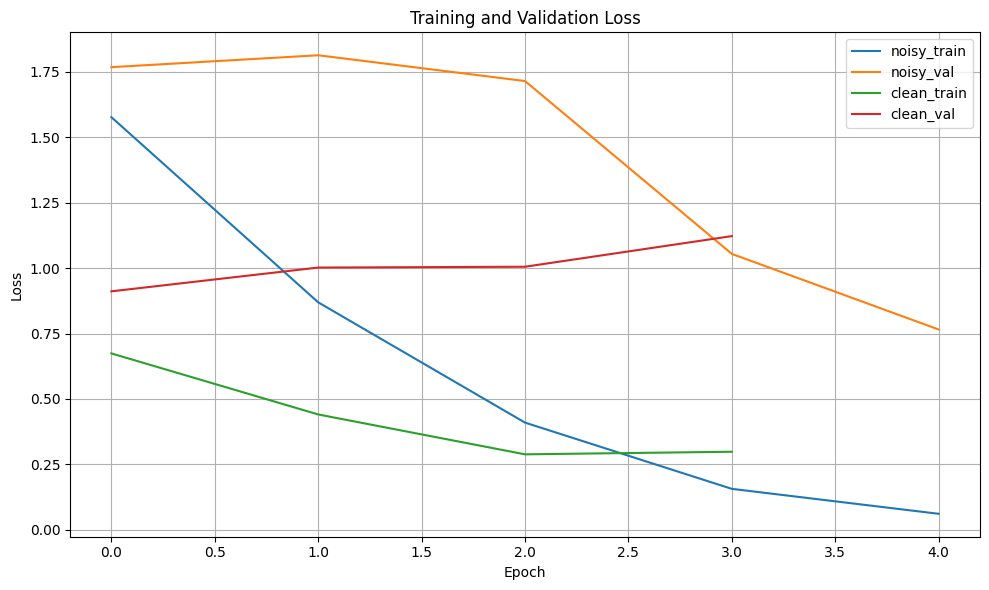

In [ ]:
plot_training_curves(history)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

In [ ]:
def evaluate_model(model, dataloader, device, num_classes=6):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            probs = torch.softmax(outputs, dim=1)  # ← 各クラスの確率
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [ ]:
def show_confusion_matrix(labels, preds, class_names=None):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names))

In [ ]:
def show_roc_auc(labels, probs, num_classes=6):
    plt.figure(figsize=(7, 5))

    for class_idx in range(num_classes):
        true_binary = (labels == class_idx).astype(int)
        class_probs = probs[:, class_idx]

        fpr, tpr, _ = roc_curve(true_binary, class_probs)
        auc = roc_auc_score(true_binary, class_probs)

        plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
class_map_df = df[['indication_value', 'indication_type']].drop_duplicates().sort_values('indication_value')

# クラスID順にソートしてリスト化
class_names = class_map_df['indication_type'].tolist()


In [ ]:
# テストデータ
test_dataset = TextileImageDataset(os.path.join(extract_path, 'test64.h5'), os.path.join(extract_path,'test64.csv'), transform=transform)
test_subset_size = 300
test_dataset, _ = random_split(test_dataset, [test_subset_size, len(test_dataset) - test_subset_size])

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 推論
labels, preds, probs = evaluate_model(model, test_loader, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

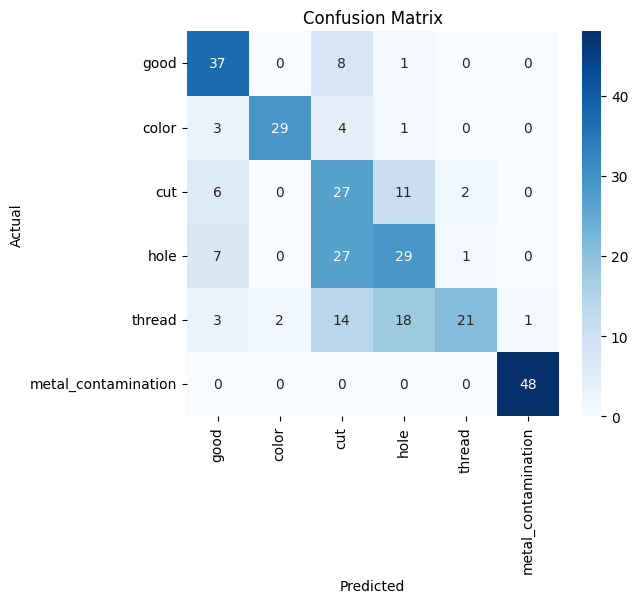


Classification Report:
                     precision    recall  f1-score   support

               good       0.66      0.80      0.73        46
              color       0.94      0.78      0.85        37
                cut       0.34      0.59      0.43        46
               hole       0.48      0.45      0.47        64
             thread       0.88      0.36      0.51        59
metal_contamination       0.98      1.00      0.99        48

           accuracy                           0.64       300
          macro avg       0.71      0.66      0.66       300
       weighted avg       0.70      0.64      0.64       300



In [ ]:
# 混同行列
show_confusion_matrix(labels, preds, class_names=class_names)

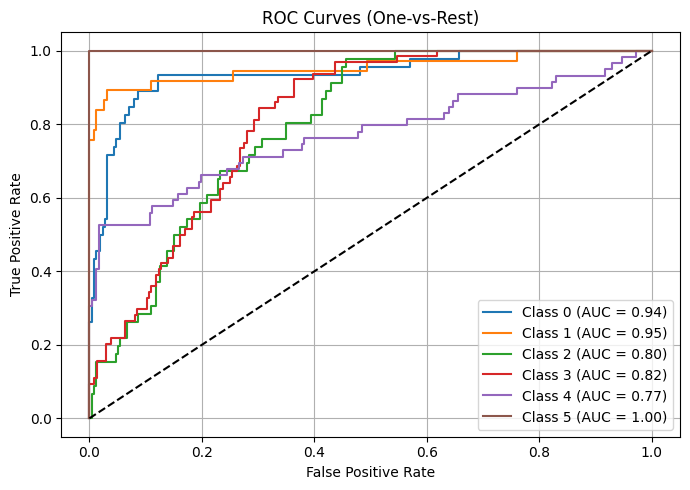

In [ ]:
# ROC / AUC
show_roc_auc(labels, probs, num_classes=len(class_names))

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s e

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
target_layer = model.Mixed_7c

In [ ]:
def run_gradcam(model, dataset, index, device, class_names=None):
    model.eval()
    img_tensor, label, category = dataset[index]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=[target_layer])

    targets = [ClassifierOutputTarget(label)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # (H, W), 0〜1

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = img_np / img_np.max()

    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original: {category}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


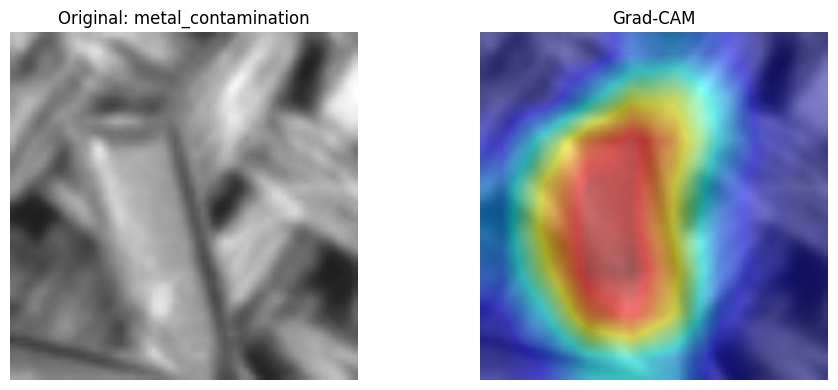

In [ ]:
run_gradcam(model, test_dataset, index=6, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), class_names=class_names)